# Define Python Functions

In [14]:
import scipy
import os
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image
from astropy.io import ascii
from astropy.time import Time

from google.colab import output
output.enable_custom_widget_manager()

import ipywidgets as widgets
%matplotlib ipympl

# Download Supernova Spectral Data

In [15]:
# Download files
objs=['2016gkg','2021pfs','2019yvr','2017ein','2022mxv','2020tlf','2019abn','2023ixf']
filenames=[o+'.csv' for o in objs]
for obj in objs:
    if os.path.exists(f'{obj}.csv'):
        print(f'{obj}.csv exists')
        continue
    cmd = f'wget https://raw.githubusercontent.com/charliekilpatrick/SN_classification/main/{obj}.csv'
    os.system(cmd)

2016gkg.csv exists
2021pfs.csv exists
2019yvr.csv exists
2017ein.csv exists
2022mxv.csv exists
2020tlf.csv exists
2019abn.csv exists
2023ixf.csv exists


# Defining a spectrum object to help analyze data

In [16]:
def is_number(val):
    try:
        x = float(val)
        return(True)
    except ValueError:
        return(False)

class spectrum(object):
    def __init__(self, specfile):

        self.wavelength = None
        self.flux = None
        self.flux_err = None

        self.meta = {}

        self.load_spectrum(specfile)

    def load_spectrum(self, filename):

        table = ascii.read(filename)
        self.wavelength = table['wavelength']
        self.flux = table['flux']
        self.flux_err = table['fluxerr']

        meta = table.meta['comments']
        for pair in meta:
            data = pair.split(':')
            key = data[0]
            val = ':'.join(data[1:])
            key = key.strip() ; val = val.strip()
            if is_number(val):
                self.meta[key]=float(val)
            else:
                self.meta[key]=val

        self.meta['name'] = filename.replace('.csv','')

        if 'OBS_DATE' in self.meta.keys():
            val = self.meta['OBS_DATE']
            if '+' in val: val = val.split('+')[0]
            self.meta['OBS_DATE'] = Time(val)

    def get_rest_spectrum(self, normalize=True):

        wave = None
        flux = None
        if 'REDSHIFT' in self.meta.keys():
            wave = self.wavelength/(1+self.meta['REDSHIFT'])
        else:
            wave = self.wavelength
        if normalize:
            flux = self.flux / np.mean(self.flux)
        else:
            flux = self.flux

        return(wave, flux)

    def get_wave_limits(self):

        wave = self.wavelength
        wave_range = np.max(wave) - np.min(wave)
        limits = [np.min(wave) - 0.03 * wave_range, np.max(wave) + 0.03 * wave_range]
        return(limits)

In [52]:
def plot_spectrum(ax, specname, HI=False, HeI=False, SiII=False, CaII=False, OI=False, FeII=False):

    ax.cla()

    if not specname.endswith('.csv'): specname = specname+'.csv'
    spec = spectrum(specname)

    add_lines = {'H I': np.array([4101.73, 4340.47, 4861.35, 6562.82]),
         'He I': np.array([5875.62, 6678.15, 7065.19, 7281.35 ]),
         'Si II': np.array([5978.93, 6347.10]),
         'Ca II': np.array([3800, 8300 ]),
         'O I': np.array([7778]),
         'Fe II': np.array([4400])}

    ax.set_title(spec.meta['name'], fontsize=30)

    ax.set_xlim(*spec.get_wave_limits())
    ax.set_ylabel('Relative Flux', fontsize=30)
    ax.set_xlabel('Wavelength (Angstroms)', fontsize=30)

    label = spec.meta['name']+' on '+spec.meta['OBS_DATE'].datetime.strftime('%Y-%m-%d')
    ax.plot(*spec.get_rest_spectrum(), color='k', label=label)

    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    colors = ['red','orange','goldenrod','darkgreen','blue','magenta']
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    for i,line in enumerate(list(add_lines.keys())):
        if line=='H I' and not HI: continue
        if line=='He I' and not HeI: continue
        if line=='Si II' and not SiII: continue
        if line=='Ca II' and not CaII: continue
        if line=='O I' and not OI: continue
        if line=='Fe II' and not FeII: continue

        label = line
        for val in add_lines[line]:
            ax.vlines(val, ymin-0.1*yrange, ymax+0.1*yrange, color=colors[i], linestyle='--', linewidth=4, label=label)
            label = None

    ax.set_ylim([ymin-0.1*yrange, ymax+0.1*yrange])

    plt.legend(loc='upper right', fontsize=12, framealpha=1)
    plt.tight_layout()

# Plot It

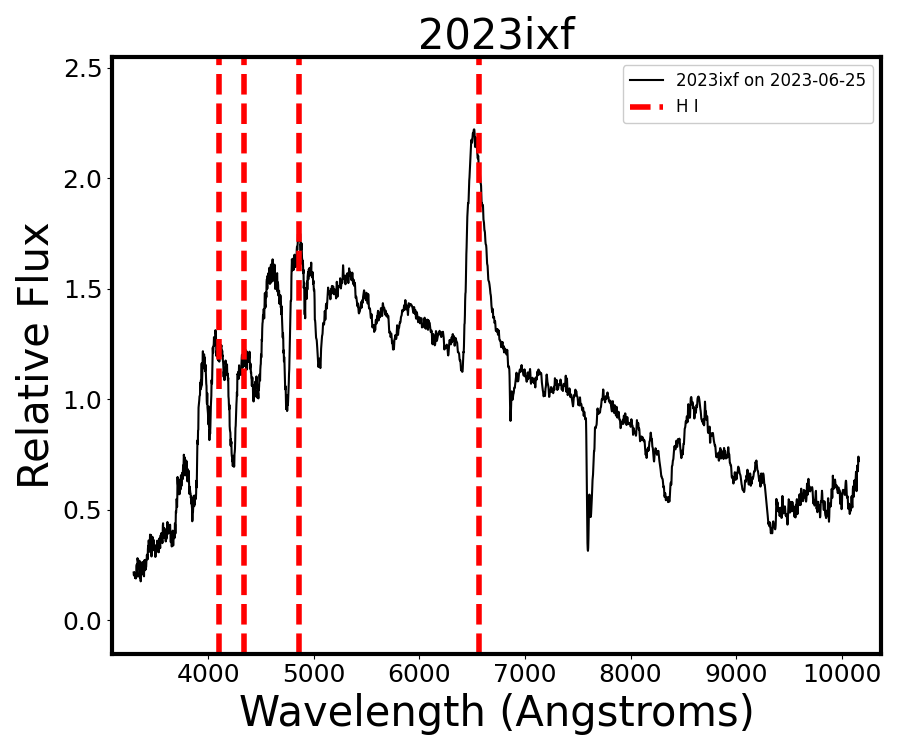

In [53]:
figsize = 5.0
fig, ax = plt.subplots()
for i in ax.spines.keys(): ax.spines[i].set_linewidth(0.6*figsize)
fig.set_size_inches(1.8*figsize, 1.5*figsize)
plot_spectrum(ax, '2023ixf', HI=True)

# What Elements are Present?


This is the classification process, in an overview. Take a moment to note the important elements you'll need to make your decisions!

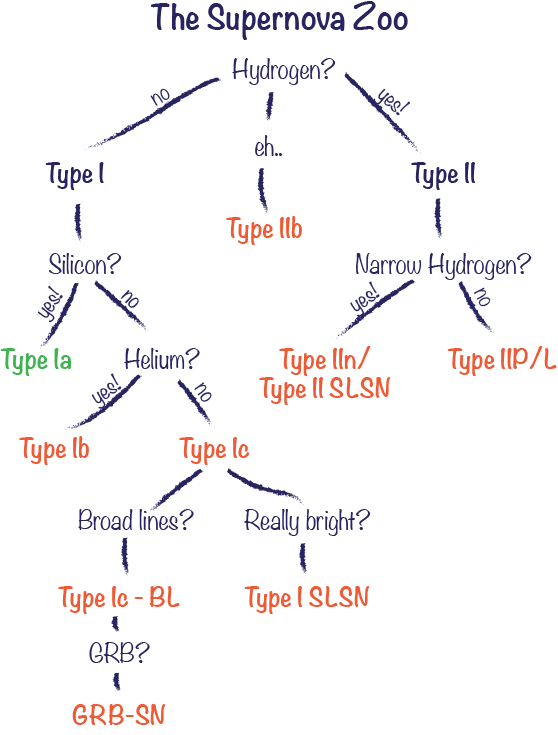


## Use the identified elements below to determine which elements are "in abundance" in your supernova.

# An interactive version of the spectrum plot

interactive(children=(Dropdown(description='Object:', options=('2016gkg', '2021pfs', '2019yvr', '2017ein', '20…

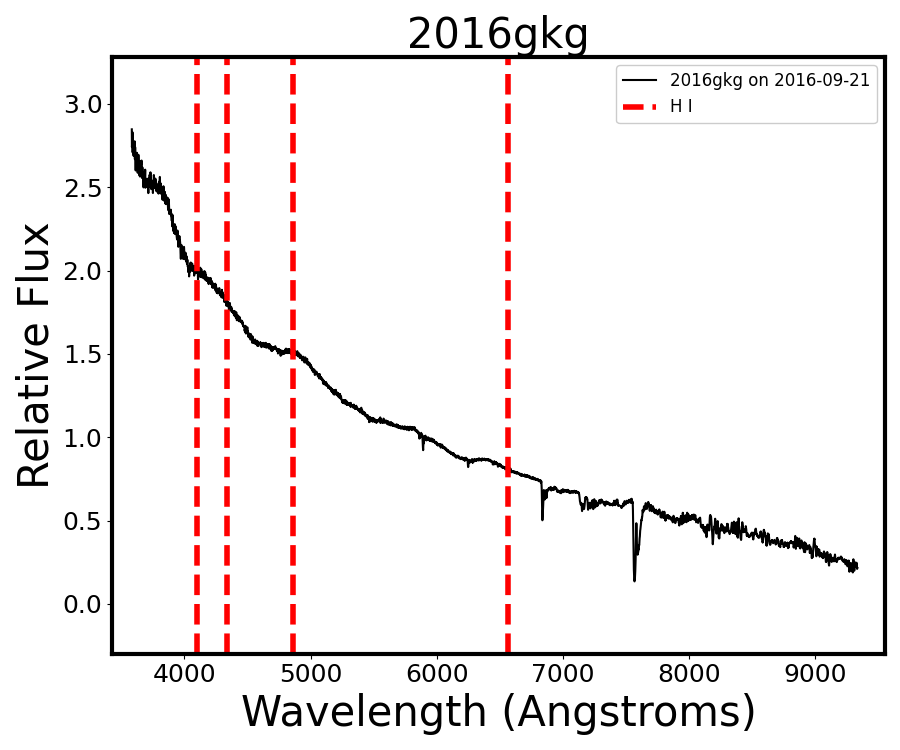

In [54]:
figsize = 5.0
fig, ax = plt.subplots()
for i in ax.spines.keys(): ax.spines[i].set_linewidth(0.6*figsize)
fig.set_size_inches(1.8*figsize, 1.5*figsize)
@widgets.interact(specname=widgets.Dropdown(options=objs,value=objs[0],description='Object:',disabled=False,),
         HI=widgets.Checkbox(value=True,description='H I',disabled=False),
         HeI=widgets.Checkbox(value=False,description='He I',disabled=False,indent=True),
         SiII=widgets.Checkbox(value=False,description='Si II',disabled=False,indent=True),
         CaII=widgets.Checkbox(value=False,description='Ca II',disabled=False,indent=True),
         OI=widgets.Checkbox(value=False,description='O I',disabled=False,indent=True),
         FeII=widgets.Checkbox(value=False,description='Fe II',disabled=False,indent=True))
def update(specname='2023ixf.csv', HI=True, HeI=False, SiII=False, CaII=False, OI=False, FeII=False):
  plot_spectrum(ax, specname, HI=HI, HeI=HeI, SiII=SiII, CaII=CaII, OI=OI, FeII=FeII)

# Reflect + Discuss

Prepare your case to present to the other group:

*   What SN type is it?

I belive it to be a Type Ia SN
*   Why? How do you know?

I belive this because it has traces of Iron, Calcium, Silicon, and Oxygen. This matches with the emissons of Type Ia SN.

Your justification should include mention of different metals, their relative abundances, matches to other supernova types, etc.


<br> Bonus question: What type of SN do you think is a close second place, if any? Was your classification a clear cut, or was it a little hard to decide? What do you think happens in this case?